# Up/Down decon with stochastic gradient algorithms and multiple virtual sources

In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torchvision
import torch.nn as nn
import pylops_gpu

from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt,convolve, hilbert
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from stochmdd import MDDminibatch, MDDpage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data loading

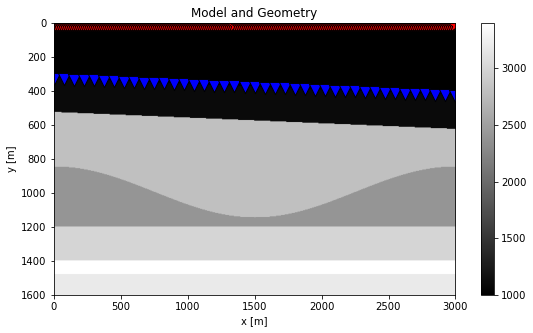

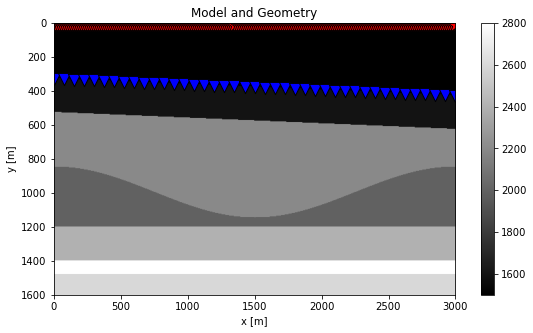

In [2]:
datapath = '../Data'

inputfile = os.path.join(datapath, 'input_dipping_recsolid.npz')

vel_dir = 1500.0 # velocity of water
vel_sep = 1600.0 # velocity at separation level
rho_sep = 1100.0 # density at separation level

#method = 'sum'
#method = 'rec_ana'
method = 'src_ana'
#method = 'src_inv'

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
r = r[:, 201:]
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 941, 0.005
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

plt.figure(figsize=(9,5))
im = plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

Up/down separated data

In [3]:
data = np.load('../Data/updown_dipping_belowseabed_%s.npz'% method)

pup = data['pup'] 
pdown = data['pdown'] 

Reference Reflection response

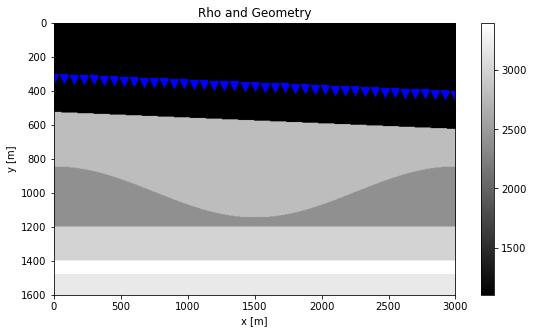

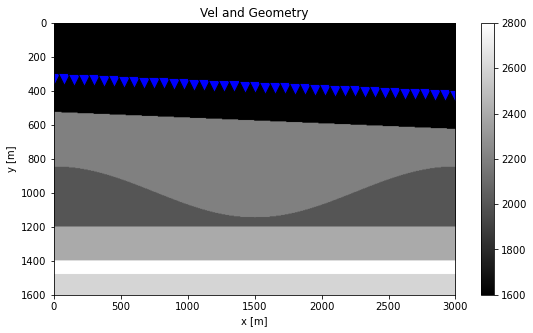

In [4]:
inputfile = os.path.join(datapath, 'input_dipping_noseabed_recsolid.npz')
inputdata = np.load(inputfile)

# data
R = -inputdata['vz_noseabed']

# Model
rho_ref = inputdata['rho_noseabed']
vel_ref = inputdata['vel_noseabed']

plt.figure(figsize=(9,5))
im = plt.imshow(rho_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Rho and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Vel and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

## Data preparation

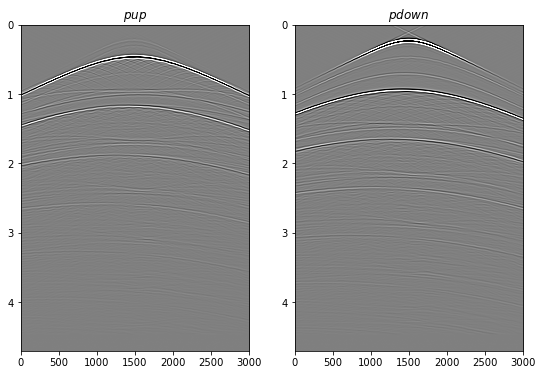

In [5]:
# Pad data with zero at the end (to avoid wrap around)
npad = 50 # 400
pdown = np.pad(pdown, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
pup = np.pad(pup, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
R = np.pad(R, ((1, npad), (0, 0) ))#.astype('float32')
ntpad = pup.shape[1]
tpad = np.arange(ntpad) * dt
tpad2 = np.hstack((-tpad[::-1], tpad[1:]))

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight');

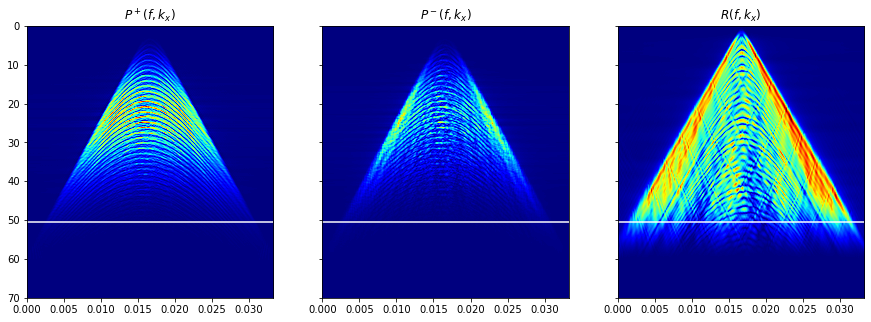

In [6]:
# check max frequency to use
nfmax=250#550
nfft = ntpad#2**11

FFTop = FFT2D(dims=[nr, ntpad], nffts=[nfft, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[ns//2].T.flatten()).reshape(nfft, nfft)
PDOWN = (FFTop*pdown[ns//2].T.flatten()).reshape(nfft, nfft)
RTRUE = (FFTop*R.T.ravel()).reshape(nfft, nfft)

# mask away high freqs
mask = np.zeros((nfft, nfft))
mask[:, :nfmax] = 1
mask[:, -nfmax:] = 1
mask = filtfilt(np.ones(50)/50, 1, mask, axis=1)
RTRUE *= mask
R = np.real(FFTop.H * RTRUE.ravel()).reshape(nr, ntpad).T

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight')
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[nfmax], color='w')
axs[2].set_title(r'$R(f, k_x)$')
axs[2].axis('tight')
axs[2].set_ylim(70, 0);

## Benchmark MDD

In [7]:
# 10 vs
#ivs = 5
#nvsin = nr//2-5
#nvsend = nr//2+6

# all vs
ivs = nr//2
nvsin = 0
nvsend = nr
nvs = nvsend-nvsin
nvs

201

In [8]:
def errnorm(m, mtrue, enorm, nvs, ivs):
    m = m.reshape(mtrue.shape[0], mtrue.shape[1], nvs)[...,ivs]
    enorm.append(np.linalg.norm(m.ravel()/m.ravel().max() - mtrue.ravel()/mtrue.ravel().max()))

In [9]:
niter = 10
bench_enorm = []
Rinv, Radj = MDD(pdown.transpose(0, 2, 1), pup[:, :, nvsin:nvsend].transpose(0, 2, 1), dt=dt, dr=dr, 
                 nfmax=nfmax, twosided=False,
                 adjoint=True, psf=False, dtype='complex64', dottest=True,
                 **dict(damp=1e-10, niter=niter, show=1, 
                        callback=lambda x: errnorm(x, R, bench_enorm, nvs, ivs),))

Dot test passed, v^T(Opu)=-142875.118335 - u^T(Op^Tv)=-142875.118335
CGLS
-----------------------------------------------------------
The Operator Op has 40037391 rows and 40037391 cols
damp = 1.000000e-10	tol = 1.000000e-04	niter = 10
-----------------------------------------------------------
    Itn           x[0]              r1norm          r2norm
     1         2.2692e-04         1.0619e+02      1.0619e+02
     2         6.2755e-04         7.7786e+01      7.7786e+01
     3         1.0729e-03         5.9730e+01      5.9730e+01
     4         1.4738e-03         4.8112e+01      4.8112e+01
     5         1.8576e-03         3.9970e+01      3.9970e+01
     6         2.2500e-03         3.3917e+01      3.3917e+01
     7         2.6189e-03         2.9632e+01      2.9632e+01
     8         2.9837e-03         2.6409e+01      2.6409e+01
     9         3.3828e-03         2.3792e+01      2.3792e+01
    10         3.7982e-03         2.1695e+01      2.1695e+01

Iterations = 10        Total time 

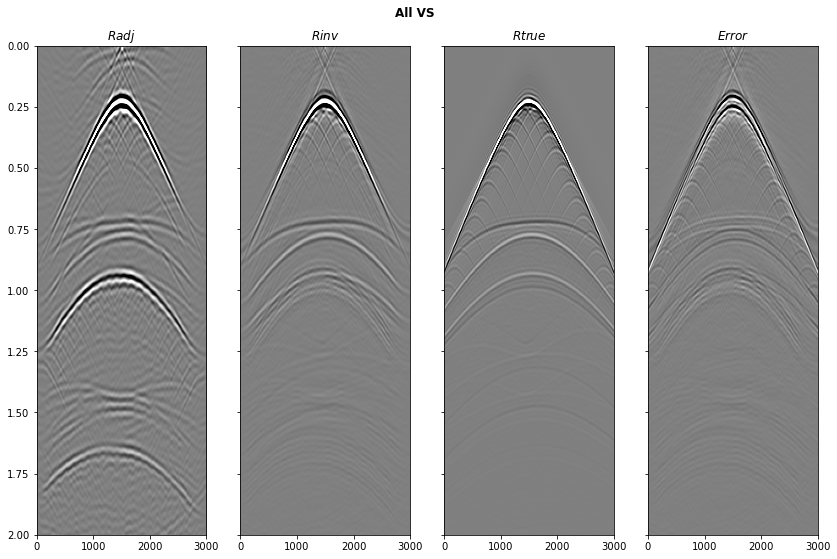

In [10]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(14,9))
fig.suptitle('All VS', fontweight='bold', y=0.94)
axs[0].imshow(Radj[:, ivs].T, cmap='gray', 
              vmin=-0.2*np.abs(Radj[:, ivs]).max(), vmax=0.2*np.abs(Radj[:, ivs]).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rinv[:, ivs].T, cmap='gray', 
              vmin=-0.2*np.abs(Rinv[:, ivs]).max(), vmax=0.2*np.abs(Rinv[:, ivs]).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(R, cmap='gray', 
              vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'$Rtrue$')
axs[2].axis('tight')
axs[2].set_ylim(2, -2)
axs[3].imshow(Rinv[:, ivs].T/np.max(Rinv[:, ivs].T)-R/np.max(R), cmap='gray', 
              vmin=-0.2, vmax=0.2,
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[3].set_title(r'$Error$')
axs[3].axis('tight')
axs[3].set_ylim(2, 0);

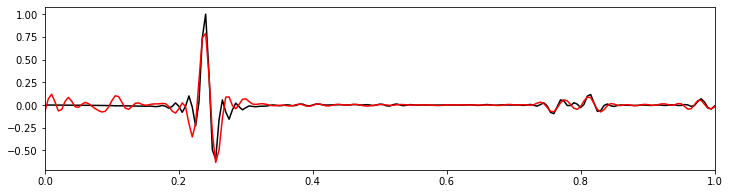

In [11]:
plt.figure(figsize=(12, 3))
plt.plot(tpad, R[:, ns//2]/np.max(R[:, ns//2]), 'k')
plt.plot(tpad, Rinv[:, ivs][ns//2]/np.max(Rinv[ns//2]), 'r')
plt.xlim(0, 1.);

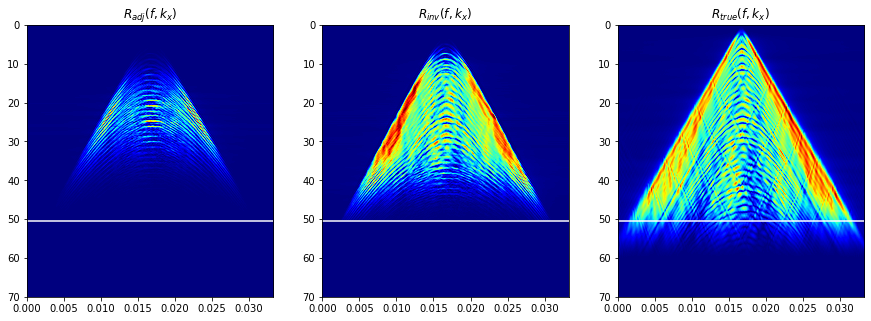

In [12]:
RADJ = (FFTop*Radj[:, ivs].ravel()).reshape(nfft, nfft)
RINV = (FFTop*Rinv[:, ivs].ravel()).reshape(nfft, nfft)
RTRUE = (FFTop*R.T.ravel()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(RADJ[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RADJ).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$R_{adj}(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(70, 0)
im=axs[1].imshow(np.fft.fftshift(np.abs(RINV[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RINV).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$R_{inv}(f, k_x)$')
axs[1].axis('tight')
axs[1].set_ylim(70, 0)
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[nfmax], color='w')
axs[2].set_title(r'$R_{true}(f, k_x)$')
axs[2].axis('tight');
axs[2].set_ylim(70, 0);

## Stochastic MDD

In [13]:
# 1.
#nepochs = niter
#batch_size = 11

# 2.
#nepochs = niter
#batch_size = 21

# 3.
nepochs = niter
batch_size = 32

# 4.
#nepochs = niter
#batch_size = 64

no_of_batches=np.ceil(ns/batch_size)
lossdict = {}
avgdict = {}
enormdict = {}
mdict = {}

In [14]:
pup = pup[:, :, nvsin:nvsend].transpose(1, 0, 2)
pdown = pdown.transpose(1, 0, 2)

In [15]:
pdown_fft = np.fft.rfft(pdown, ntpad-1, axis=0)
pdown_fft = pdown_fft[:nfmax]

MDCop=MDC(pdown_fft, nt=ntpad, nv=nvs, dt=dt, dr=dr, 
          twosided=False, transpose=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=0, verb=True);

Dot test passed, v^T(Opu)=-215784.913858 - u^T(Op^Tv)=-215784.913858


In [16]:
# Adjoint
madj = MDCop.H * pup.ravel()
madj = madj.reshape(ntpad, nr, nvs)

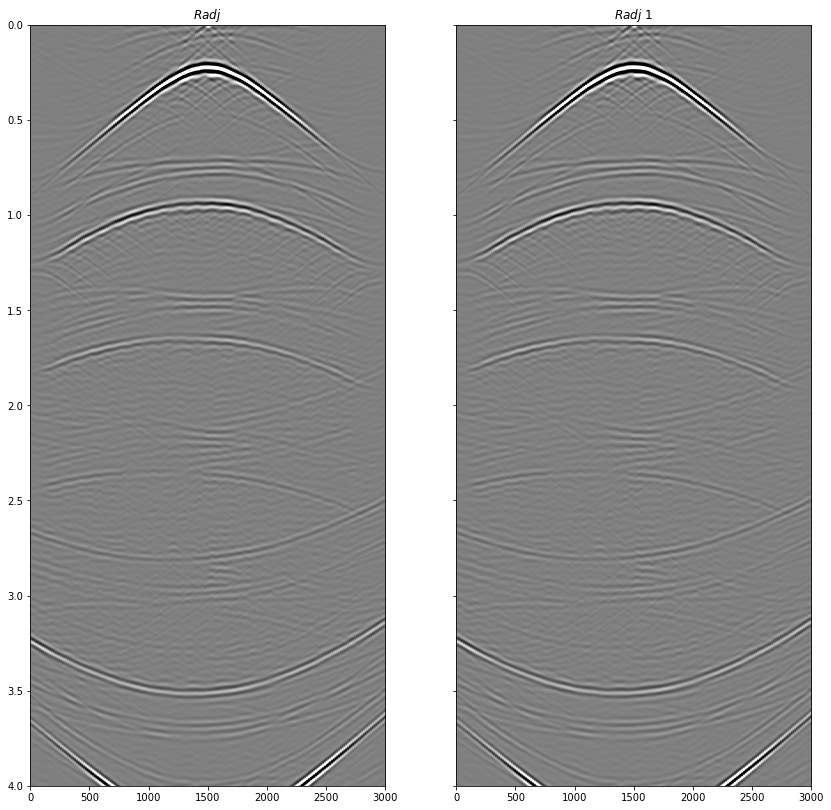

In [17]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14,14))
axs[0].imshow(Radj[:, ivs].T, cmap='gray', 
              vmin=-0.2*np.abs(Radj).max(), vmax=0.2*np.abs(Radj).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(madj[:, :, ivs], cmap='gray',
              vmin=-0.2*np.abs(madj).max(), vmax=0.2*np.abs(madj).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$Radj$ 1')
axs[1].axis('tight')
axs[1].set_ylim(4, 0);

In [18]:
R = torch.from_numpy(R)
pdown_fft = torch.from_numpy(5*pdown_fft)
pup = torch.from_numpy(5*pup)

### SGD

In [19]:
lr = {}

# 10 vs
#lr[11] = 0.04
#lr[21] = 0.01
lr[32] = 0.2
#lr[64] = 0.01

# all vs
#lr[11] = 0.04
#lr[21] = 0.01
lr[32] = 2.
#lr[64] = 0.01

model, dmod, lossdict['SGD'], avgdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=R, ivstrue=ivs, seed=0, epochprint=5,
                              **dict(lr=lr[batch_size], weight_decay=0))
mdict["SGD"] = model.detach().numpy()

epoch:   5, loss : 2.0265e-03, loss avg : 2.1315e-03
epoch:  10, loss : 9.6755e-04, loss avg : 9.2276e-04


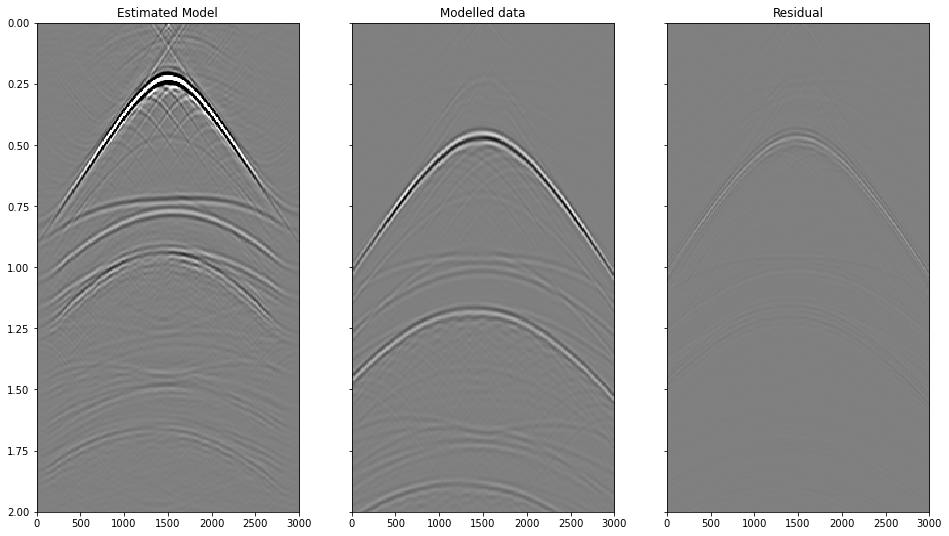

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model[..., ivs].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-1e-3, vmax=1e-3,
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod[..., ivs].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup[..., ivs].detach().numpy().max(), vmax=pup[..., ivs].detach().numpy().max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod[..., ivs]-pup[..., ivs]).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup[..., ivs].detach().numpy().max(), vmax=pup[..., ivs].detach().numpy().max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(2, 0);

### SGD with momentum

In [21]:
lr = {}

# 10 vs
#lr[11] = 0.002
#lr[21] = 0.005
lr[32] = 0.1
#lr[64] = 0.01

# all vs
#lr[11] = 0.002
#lr[21] = 0.005
lr[32] = 2. #1.
#lr[64] = 0.01

model, dmod, lossdict['SGDMom'], avgdict['SGDMom'], enormdict['SGDMom'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=R, ivstrue=ivs, 
                              seed=0, epochprint=5,
                              **dict(lr=lr[batch_size], momentum=0.9, nesterov=True))

mdict["SGDMom"] = model.detach().numpy()

epoch:   5, loss : 1.1685e-03, loss avg : 1.5737e-03
epoch:  10, loss : 3.0215e-04, loss avg : 3.5216e-04


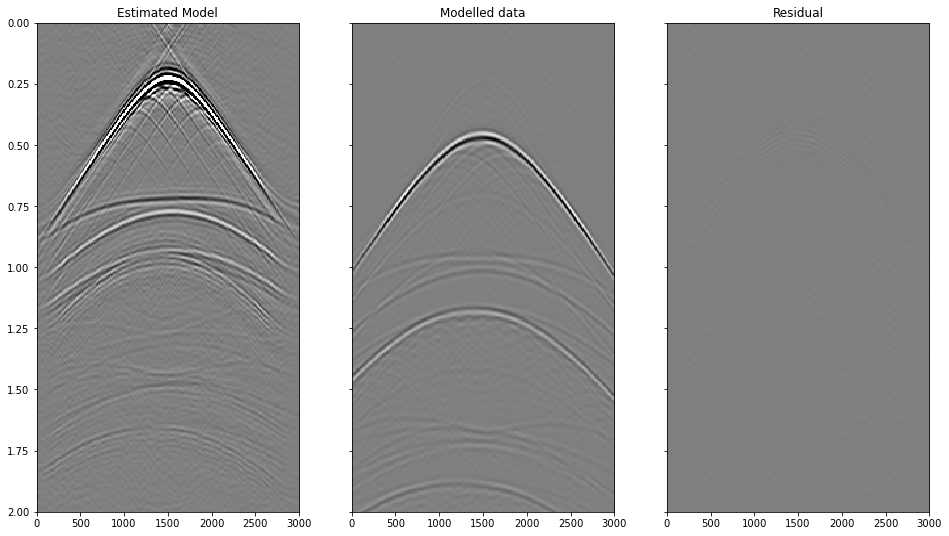

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model[..., ivs].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-1e-3, vmax=1e-3,
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod[..., ivs].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup[..., ivs].detach().numpy().max(), vmax=pup[..., ivs].detach().numpy().max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod[..., ivs]-pup[..., ivs]).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup[..., ivs].detach().numpy().max(), vmax=pup[..., ivs].detach().numpy().max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(2, 0);

### SGD with momentum and exponential LR

In [23]:
lr = {}
#lr[11] = 0.006
#lr[21] = 0.01
lr[32] = 1.5
#lr[64] = 0.01

model, dmod, lossdict['SGDMom_LRexp'], avgdict['SGDMom_LRexp'], enormdict['SGDMom_LRexp'], lr = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=R, ivstrue=ivs, seed=0,
                              scheduler=torch.optim.lr_scheduler.ExponentialLR, epochprint=5,
                              kwargs_sched=dict(gamma=0.99, last_epoch=-1, verbose=False),
                              **dict(lr=lr[batch_size], momentum=0.9, nesterov=True))
                 
mdict["SGDMom_LRexp"] = model.detach().numpy()

epoch:   5, loss : 6.1411e-04, loss avg : 7.3561e-04
epoch:  10, loss : 2.0086e-04, loss avg : 1.8491e-04


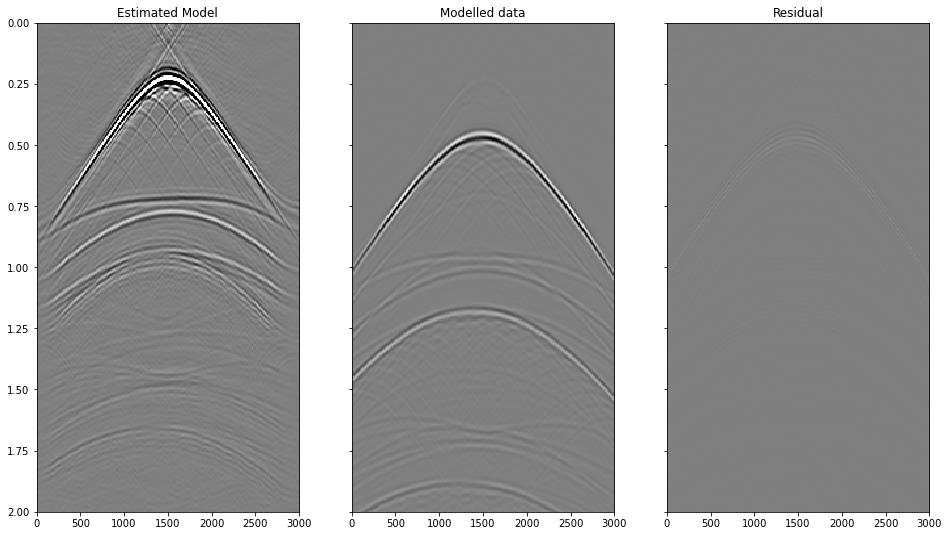

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model[..., ivs].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-1e-3, vmax=1e-3,
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod[..., ivs].detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup[..., ivs].detach().numpy().max(), vmax=pup[..., ivs].detach().numpy().max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod[..., ivs]-pup[..., ivs]).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup[..., ivs].detach().numpy().max(), vmax=pup[..., ivs].detach().numpy().max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(2, 0);

## Comparison

9.285358137654821
10.59518151298509
7.624142938554204
8.370405461334448


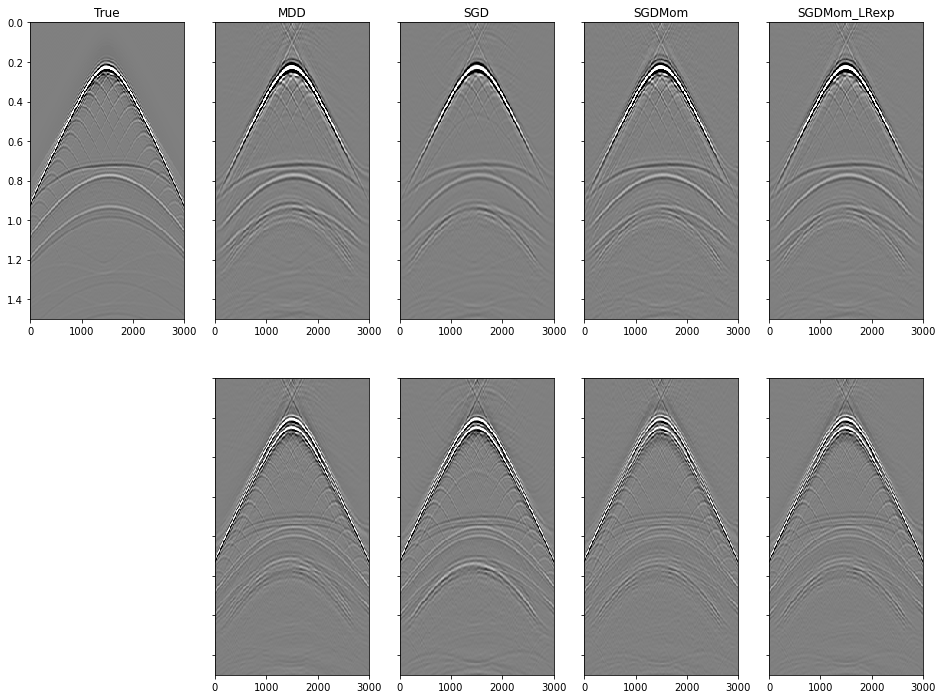

In [25]:
clip = 0.2

fig, axs = plt.subplots(2, len(mdict)+2, sharey=True, figsize=(16, 12))
axs[0][0].imshow(R, aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip*R.max(), vmax=clip*R.max(),
                 extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0][0].axis('tight')
axs[0][0].set_title('True')
axs[0][1].imshow(Rinv[:, ivs].T, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*Rinv[:, ivs].max(), vmax=clip*Rinv[:, ivs].max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0][1].axis('tight')
axs[0][1].set_title('MDD')
print(np.linalg.norm(Rinv[:, ivs].T.ravel()/Rinv[:, ivs].T.ravel().max() - R.numpy().ravel()/R.numpy().ravel().max()))

for iloss, loss in enumerate(mdict.keys()):
    axs[0][iloss+2].imshow(mdict[loss][..., ivs], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*mdict['SGDMom'][..., ivs].max(), vmax=clip*mdict['SGDMom'][..., ivs].max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
    axs[0][iloss+2].axis('tight')
    axs[0][iloss+2].set_title(loss)
    print(np.linalg.norm(mdict[loss][..., ivs].ravel()/mdict[loss][..., ivs].ravel().max() - R.numpy().ravel()/R.numpy().ravel().max()))
axs[0][-1].set_ylim(1.5, 0)

axs[1][0].axis('off')
axs[1][1].imshow(R/R.max()-Rinv[:, ivs].T/Rinv[:, ivs].max(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip, vmax=clip,
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1][1].axis('tight')

for iloss, loss in enumerate(mdict.keys()):
    axs[1][iloss+2].imshow(R/R.max()-mdict[loss][..., ivs]/mdict[loss][..., ivs].max(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip, vmax=clip,
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
    axs[1][iloss+2].axis('tight')
axs[1][-1].set_ylim(1.5, 0);
plt.savefig('Figs/MDDMulti_nvs%d_solutions_batch%d_nepoch%d' % (nvs, batch_size, nepochs))

8.846734037800843
9.95551961326063
7.272306692443332
8.012630943798548


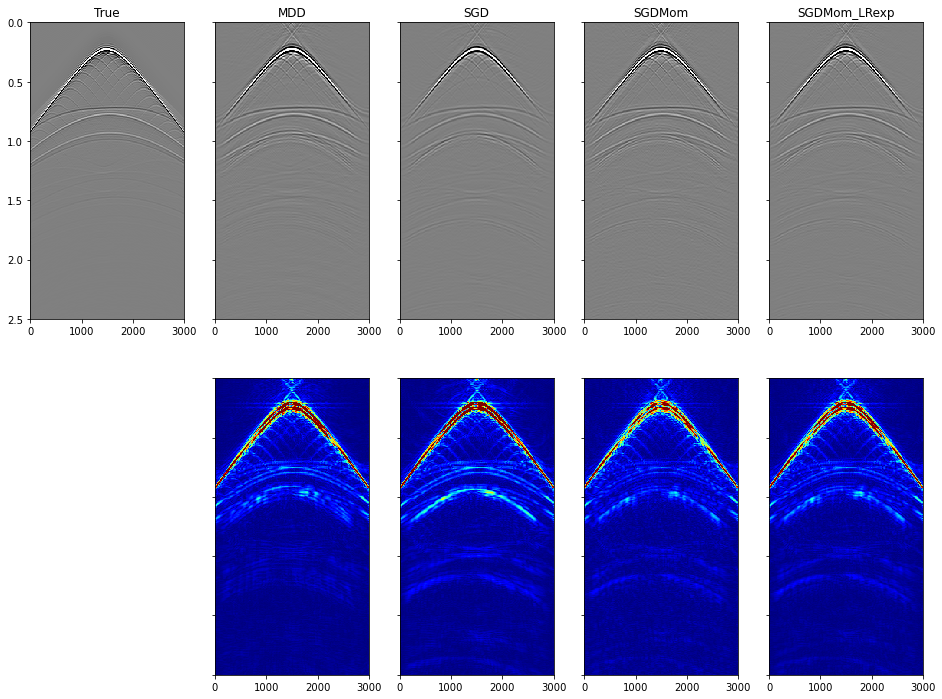

In [52]:
clip = 0.2
itmax = 500
fig, axs = plt.subplots(2, len(mdict)+2, sharey=True, figsize=(16, 12))
axs[0][0].imshow(R, aspect='auto', interpolation='nearest', cmap='gray',
                 vmin=-clip*R.max(), vmax=clip*R.max(),
                 extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0][0].axis('tight')
axs[0][0].set_title('True')
axs[0][1].imshow(Rinv[:, ivs].T, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*Rinv[:, ivs].max(), vmax=clip*Rinv[:, ivs].max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0][1].axis('tight')
axs[0][1].set_title('MDD')
print(np.linalg.norm(Rinv[:, ivs, :itmax].T.ravel()/Rinv[:, ivs, :itmax].T.ravel().max() - R[:itmax].numpy().ravel()/R[:itmax].numpy().ravel().max()))

for iloss, loss in enumerate(mdict.keys()):
    axs[0][iloss+2].imshow(mdict[loss][..., ivs], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*mdict['SGDMom'][..., ivs].max(), vmax=clip*mdict['SGDMom'][..., ivs].max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
    axs[0][iloss+2].axis('tight')
    axs[0][iloss+2].set_title(loss)
    print(np.linalg.norm(mdict[loss][:itmax, :, ivs].ravel()/mdict[loss][:itmax, :, ivs].ravel().max() - R[:itmax].numpy().ravel()/R[:itmax].numpy().ravel().max()))
axs[0][-1].set_ylim(t[itmax], 0)

axs[1][0].axis('off')
axs[1][1].imshow(np.abs(hilbert(R/R.max()-Rinv[:, ivs].T/Rinv[:, ivs].max())), 
                 aspect='auto', interpolation='nearest', cmap='jet',
                 vmin=0, vmax=clip,
                 extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1][1].axis('tight')

for iloss, loss in enumerate(mdict.keys()):
    axs[1][iloss+2].imshow(np.abs(hilbert(R/R.max()-mdict[loss][..., ivs]/mdict[loss][..., ivs].max())), 
                                  aspect='auto', interpolation='nearest', cmap='jet',
                                  vmin=0, vmax=clip,
                                  extent = (r[0, 0], r[0,-1], t[-1], t[0]))
    axs[1][iloss+2].axis('tight')
axs[1][-1].set_ylim(t[itmax], 0);
plt.savefig('Figs/MDDMulti_nvs%d_solutions_batch%d_nepoch%d' % (nvs, batch_size, nepochs))

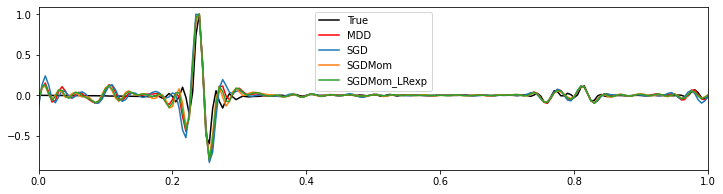

In [26]:
plt.figure(figsize=(12, 3))
plt.plot(tpad, R[:, ns//2]/R[:, ns//2].max(), 'k', label='True')
plt.plot(tpad, Rinv[ns//2, ivs]/Rinv[ns//2, ivs].max(), 'r', label='MDD')
for iloss, loss in enumerate(mdict.keys()):
    plt.plot(tpad,mdict[loss][:, ns//2, ivs]/mdict[loss][:, ns//2, ivs].max(), label=loss)
plt.legend()
plt.xlim(0, 1.);

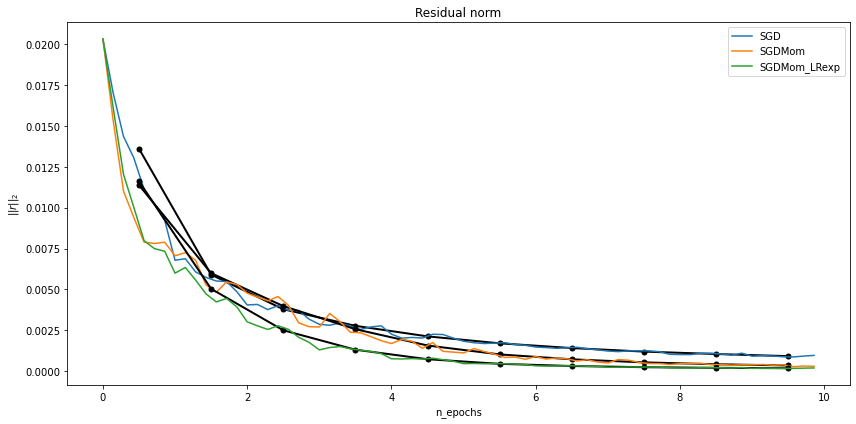

In [27]:
fig = plt.figure(figsize= (12,6))
for loss, avg in zip(lossdict.keys(), avgdict.keys()):
    plt.plot((np.arange(0, no_of_batches*nepochs, no_of_batches))/no_of_batches+0.5, avgdict[avg], '.-k', ms=10,
             linewidth = 2)
    plt.plot(np.arange(len(lossdict[loss]))/no_of_batches, lossdict[loss], label=loss)
plt.xlabel('n_epochs')
plt.ylabel(r'$||r||_2$')
plt.title("Residual norm")
plt.legend()
plt.tight_layout()
plt.savefig('Figs/MDDMulti_nvs%d_residual_norms_batch%d_nepoch%d' % (nvs, batch_size, nepochs))

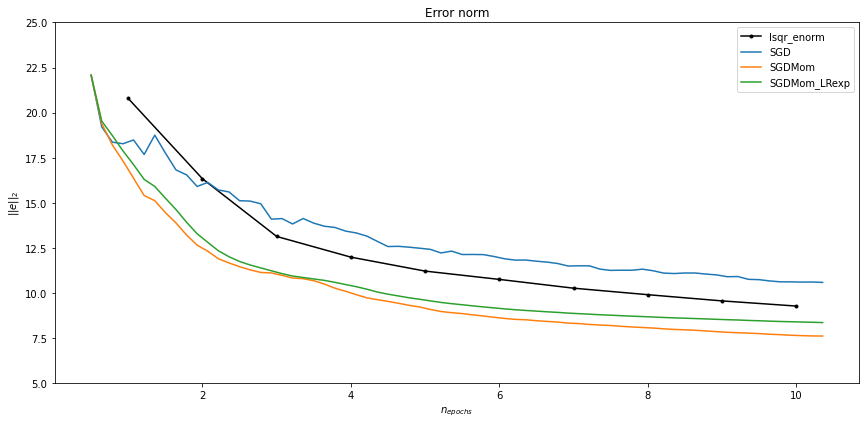

In [28]:
fig = plt.figure(figsize= (12,6))
plt.plot(np.arange(nepochs)+1, bench_enorm[:nepochs], '.-k', label = "lsqr_enorm")
for enorm in enormdict.keys():
    plt.plot(np.arange(len(enormdict[enorm]))/no_of_batches + 0.5, enormdict[enorm], label=enorm)
plt.xlabel(r'$n_{epochs}$')
plt.ylabel(r'$||e||_2$')
plt.title("Error norm")
plt.legend()
plt.tight_layout()
plt.ylim(5, 25)
plt.savefig('Figs/MDDMulti_nvs%d_error_norms_batch%d_nepoch%d' % (nvs, batch_size, nepochs))